# Gender Recognition (3 points)

Labeled Faces in the Wild dataset. RGB images 100x100 pixels

## Goals:

* \>97% accuracy over test set
* \>92% accuracy with less than 100k parameters

In [1]:
!wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz -P dataset_gender
!tar xvzf dataset_gender/gender.tgz -C dataset_gender

--2021-03-10 14:41:22--  https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
Resolviendo www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6024:18::a27d:4412
Conectando con www.dropbox.com (www.dropbox.com)[162.125.68.18]:443... conectado.
Petición HTTP enviada, esperando respuesta... 301 Moved Permanently
Ubicación: /s/raw/zcwlujrtz3izcw8/gender.tgz [siguiente]
--2021-03-10 14:41:23--  https://www.dropbox.com/s/raw/zcwlujrtz3izcw8/gender.tgz
Reutilizando la conexión con www.dropbox.com:443.
Petición HTTP enviada, esperando respuesta... 302 Found
Ubicación: https://uc488111ef8610bfb26613dc5bbb.dl.dropboxusercontent.com/cd/0/inline/BKZlMGh4U8No7P8c1_mK-6LxQOOsJWgDOPSHZQgTWQh_iSjQbEojEMwU3_EyVuQXJJrmO6zQDev-UBcTZqK5rPP36g_iw-p9c-0dMt9OQ2yuku1Rscqu9K184-mzRR6k1Ak/file# [siguiente]
--2021-03-10 14:41:23--  https://uc488111ef8610bfb26613dc5bbb.dl.dropboxusercontent.com/cd/0/inline/BKZlMGh4U8No7P8c1_mK-6LxQOOsJWgDOPSHZQgTWQh_iSjQbEojEMwU3_EyVuQXJJrmO6zQDev-UBcTZqK5rPP36g_iw-p9c-0

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Add, Concatenate
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler as LRS
from keras.callbacks import ReduceLROnPlateau as RLRP

from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

In [3]:
batch_size = 64
epochs = 200
num_classes = 2

In [4]:
def configure_callbacks(model_id, kpi_to_monitor='val_accuracy'):
    # Without log/ or models/ subfolder as not possible to access unexisting folders
    # If possible to train with jupyter revise
    name = "gr"
    log_filename = '%s-%s.log' % (name, model_id)
    csv_logger = CSVLogger(log_filename)
    
    chk_1_model_filename = '%s-%s-{epoch:04d}-{%s:.6f}.h5' % (name, model_id, kpi_to_monitor)
    chk_2_model_filename = '%s-%s.h5' % (name, model_id)
    
    # Save best model fully not only weights after each epoch (period=1) 
    # with best accuracy value (mode=max, save_best_only=True)
    checkpoint1 = ModelCheckpoint(
        chk_1_model_filename,
        monitor=kpi_to_monitor,
        save_best_only=True,
        save_weights_only=False, 
        verbose=1, mode='max', period=1
    )

    checkpoint2 = ModelCheckpoint(
        chk_2_model_filename, 
        monitor=kpi_to_monitor,
        save_best_only=False,
        save_weights_only=False, 
        verbose=1, mode='auto', period=1
    )

    callbacks = [csv_logger, checkpoint1, checkpoint2]
    return callbacks

In [5]:
# Data Augmentation with an ImageGenerator + more variations
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=False,
                             zoom_range=[1.0,1.1],
                             rotation_range=10.0,
                             shear_range=0.1)

In [6]:
# Optimizer 
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9)

In [7]:
# Define a learning rate scheduler
def scheduler(epoch):
    if epoch < 50:
        return 0.1
    elif epoch < 75:
        return 0.01
    elif epoch < 150:
        return 0.001
    else:
        return 0.0005

scheduler_lr = LRS(scheduler)

## Load Data & Preprocess Images

In [8]:
# Load
path = 'dataset_gender/'
x_train = np.load(path + 'x_train.npy')
x_test = np.load(path + 'x_test.npy')

y_train = np.load(path + 'y_train.npy')
y_test = np.load(path + 'y_test.npy')

# Stats
print(x_train.shape)
print(x_test.shape)

print("{} {} {}".format(sum(y_train == 1), sum(y_train == 0),sum(y_train == 1)/y_train.shape[0]))
print("{} {} {}".format(sum(y_test == 1), sum(y_test == 0),sum(y_test == 1)/y_test.shape[0]))

## Transforms and Normalize
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(10585, 100, 100, 3)
(2648, 100, 100, 3)
2381 8204 0.22494095418044402
596 2052 0.22507552870090636


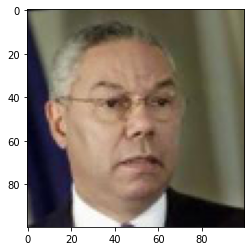

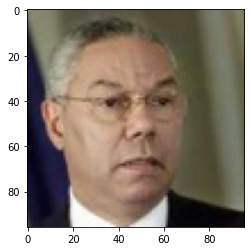

In [9]:
## View some images
plt.imshow(x_train[0,:,:,:])
plt.show()

# Image size 100x100 to 96x96 pixels - better multiple of 2

aux_train = np.zeros((x_train.shape[0], 96, 96, 3)).astype('float32')
np.array([aux_train])

for i in range(x_train.shape[0]):
    aux_train[i] = x_train[i,2:-2,2:-2,:]
    
aux_test = np.zeros((x_test.shape[0], 96, 96, 3)).astype('float32')
np.array([aux_test])

for i in range(x_test.shape[0]):
    aux_test[i] = x_test[i,2:-2,2:-2,:]
    
del(x_train)
del(x_test)

x_train = aux_train
x_test = aux_test

plt.imshow(aux_train[0,:,:,:])
plt.show()

## Auxiliar functions

In [10]:
def training_and_evaluation(model, model_id, scheduler):
    # Compile Model
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=len(x_train)/batch_size,
                        epochs=epochs,
                        shuffle=True,
                        verbose=1,
                        validation_data=(x_test, y_test),                   
                        callbacks=[configure_callbacks(model_id), scheduler])
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    print('Test error:', (1-accuracy))
    
    return model

In [11]:
def CBGN_FUNC(model, filters, gaussian_noise, kernel=(3,3)):
    x = Conv2D(filters, kernel, padding='same')(model)
    x = BN()(x)
    x = GN(gaussian_noise)(x)
    x = Activation('relu')(x)
    
    return x

## Extra funcitons

In [ ]:
# Compile Model
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=(x_test, y_test),                   
                    callbacks=[configure_callbacks(model_id), scheduler_lr])

In [ ]:
history = model.fit(datagen_plus.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train)/batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=(x_test, y_test),                   
                    callbacks=[configure_callbacks(model_id), reduce_lr])

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test error:', (1-accuracy))

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)
history = pd.read_csv("model-weights/model.log")
model = load_model("model-weights/model.h5")

## Models

### > 100 parameter models

In [71]:
# Based on best model RNA lab

inputs = keras.Input(x_train.shape[1:])
x = CBGN_FUNC(inputs, 32, 0.1)
x = CBGN_FUNC(x, 32, 0.2)
x = CBGN_FUNC(x, 32, 0.2)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = CBGN_FUNC(x, 64, 0.3)
x = CBGN_FUNC(x, 64, 0.3)
x = CBGN_FUNC(x, 64, 0.3)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = CBGN_FUNC(x, 128, 0.3)
x = CBGN_FUNC(x, 128, 0.3)
x = CBGN_FUNC(x, 128, 0.3)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = CBGN_FUNC(x, 256, 0.3)
x = CBGN_FUNC(x, 256, 0.3)
x = CBGN_FUNC(x, 256, 0.3)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = CBGN_FUNC(x, 512, 0.3)
x = CBGN_FUNC(x, 512, 0.3)
x = CBGN_FUNC(x, 512, 0.3)

x = GlobalAveragePooling2D()(x)
x = Activation('relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model_vgg = keras.Model(inputs=inputs, outputs=outputs)
model_vgg.summary()

Model: "functional_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_249 (Conv2D)          (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization_239 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
gaussian_noise_239 (Gaussian (None, 96, 96, 32)        0         
_________________________________________________________________
activation_259 (Activation)  (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_240 (Bat (None, 96, 96, 32)      

In [74]:
# Simple residual network

inputs = keras.Input(x_train.shape[1:])

x1 = CBGN_FUNC(inputs, 32, 0.1)
x2 = CBGN_FUNC(x1, 32, 0.2)
x3 = CBGN_FUNC(x2, 32, 0.2)
x = Add()([x1, x3])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 64, 0.3)
x2 = CBGN_FUNC(x1, 64, 0.3)
x3 = CBGN_FUNC(x2, 64, 0.3)
x = Add()([x1, x3])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 128, 0.3)
x2 = CBGN_FUNC(x1, 128, 0.3)
x3 = CBGN_FUNC(x2, 128, 0.3)
x = Add()([x1, x3])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 256, 0.3)
x2 = CBGN_FUNC(x1, 256, 0.3)
x3 = CBGN_FUNC(x2, 256, 0.3)
x = Add()([x1, x3])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 512, 0.3)
x2 = CBGN_FUNC(x1, 512, 0.3)
x3 = CBGN_FUNC(x2, 512, 0.3)
x = Add()([x1, x3])

x = GlobalAveragePooling2D()(x)
x = Activation('relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model_resnet = keras.Model(inputs=inputs, outputs=outputs)
model_resnet.summary()

Model: "functional_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_294 (Conv2D)             (None, 96, 96, 32)   896         input_50[0][0]                   
__________________________________________________________________________________________________
batch_normalization_284 (BatchN (None, 96, 96, 32)   128         conv2d_294[0][0]                 
__________________________________________________________________________________________________
gaussian_noise_284 (GaussianNoi (None, 96, 96, 32)   0           batch_normalization_284[0][0]    
______________________________________________________________________________________

In [76]:
# Simple dense network

inputs = keras.Input(x_train.shape[1:])

x1 = CBGN_FUNC(inputs, 32, 0.1)
x2 = CBGN_FUNC(x1, 32, 0.2)
x3 = CBGN_FUNC(x2, 32, 0.2)
x = Concatenate()([x1, x2, x3])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 32, 0.3)
x2 = CBGN_FUNC(x1, 32, 0.3)
x3 = CBGN_FUNC(x2, 32, 0.3)
x = Concatenate()([x1, x2, x3])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 32, 0.3)
x2 = CBGN_FUNC(x1, 32, 0.3)
x3 = CBGN_FUNC(x2, 32, 0.3)
x = Concatenate()([x1, x2, x3])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 64, 0.3)
x2 = CBGN_FUNC(x1, 64, 0.3)
x3 = CBGN_FUNC(x2, 64, 0.3)
x = Concatenate()([x1, x2, x3])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 64, 0.3)
x2 = CBGN_FUNC(x1, 64, 0.3)
x3 = CBGN_FUNC(x2, 64, 0.3)
x = Concatenate()([x1, x2, x3])

x = GlobalAveragePooling2D()(x)
x = Activation('relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model_densenet = keras.Model(inputs=inputs, outputs=outputs)
model_densenet.summary()

Model: "functional_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_324 (Conv2D)             (None, 96, 96, 32)   896         input_52[0][0]                   
__________________________________________________________________________________________________
batch_normalization_314 (BatchN (None, 96, 96, 32)   128         conv2d_324[0][0]                 
__________________________________________________________________________________________________
gaussian_noise_314 (GaussianNoi (None, 96, 96, 32)   0           batch_normalization_314[0][0]    
______________________________________________________________________________________

### < 100 parameter models

In [12]:
inputs = keras.Input(x_train.shape[1:])

x = CBGN_FUNC(inputs, 32, 0.1)
x = CBGN_FUNC(x, 32, 0.2)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = CBGN_FUNC(x, 32, 0.3)
x = CBGN_FUNC(x, 32, 0.3)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = CBGN_FUNC(x, 32, 0.3)
x = CBGN_FUNC(x, 64, 0.3)
x = CBGN_FUNC(x, 64, 0.3)

x = GlobalAveragePooling2D()(x)
x = Activation('relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model_vgg_mini = keras.Model(inputs=inputs, outputs=outputs)
model_vgg_mini.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 96, 96, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)       

In [13]:
inputs = keras.Input(x_train.shape[1:])

x1 = CBGN_FUNC(inputs, 32, 0.1)
x2 = CBGN_FUNC(x1, 32, 0.2)
x = Add()([x1, x2])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 32, 0.3)
x2 = CBGN_FUNC(x1, 32, 0.3)
x = Add()([x1, x2])

x = MaxPooling2D(pool_size=(2, 2))(x)

x1 = CBGN_FUNC(x, 48, 0.3)
x2 = CBGN_FUNC(x1, 64, 0.3)
x3 = CBGN_FUNC(x2, 48, 0.3)
x = Add()([x1, x3])

x = GlobalAveragePooling2D()(x)
x = Activation('relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model_resnet_mini = keras.Model(inputs=inputs, outputs=outputs)
model_resnet_mini.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 96, 96, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 96, 96, 32)   128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
gaussian_noise_7 (GaussianNoise (None, 96, 96, 32)   0           batch_normalization_7[0][0]      
_______________________________________________________________________________________

## Training

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [14]:
model_1 = model_vgg_mini
model_1 = training_and_evaluation(model=model_1,
                                  model_id='model_1',
                                  scheduler=scheduler_lr)

Epoch 1/200
166/165 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.7702
Epoch 00001: val_accuracy improved from -inf to 0.77492, saving model to gr-model_1-0001-0.774924.h5

Epoch 00001: saving model to gr-model_1.h5
166/165 [==============================] - 45s 274ms/step - loss: 0.5145 - accuracy: 0.7702 - val_loss: 0.9311 - val_accuracy: 0.7749
Epoch 2/200
166/165 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.7924
Epoch 00002: val_accuracy did not improve from 0.77492

Epoch 00002: saving model to gr-model_1.h5
166/165 [==============================] - 44s 265ms/step - loss: 0.4577 - accuracy: 0.7924 - val_loss: 0.5649 - val_accuracy: 0.6922
Epoch 3/200
166/165 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8065
Epoch 00003: val_accuracy improved from 0.77492 to 0.78927, saving model to gr-model_1-0003-0.789275.h5

Epoch 00003: saving model to gr-model_1.h5
166/165 [==============================] - 45s 27

Epoch 24/200
166/165 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9643
Epoch 00024: val_accuracy did not improve from 0.95997

Epoch 00024: saving model to gr-model_1.h5
166/165 [==============================] - 44s 263ms/step - loss: 0.0958 - accuracy: 0.9643 - val_loss: 0.5797 - val_accuracy: 0.7640
Epoch 25/200
166/165 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9615
Epoch 00025: val_accuracy did not improve from 0.95997

Epoch 00025: saving model to gr-model_1.h5
166/165 [==============================] - 44s 262ms/step - loss: 0.1005 - accuracy: 0.9615 - val_loss: 0.1744 - val_accuracy: 0.9358
Epoch 26/200
166/165 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9656
Epoch 00026: val_accuracy did not improve from 0.95997

Epoch 00026: saving model to gr-model_1.h5
166/165 [==============================] - 44s 262ms/step - loss: 0.0946 - accuracy: 0.9656 - val_loss: 0.7360 - val_accuracy: 0.8656
Epoch 2

Epoch 49/200
166/165 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9791
Epoch 00049: val_accuracy did not improve from 0.97356

Epoch 00049: saving model to gr-model_1.h5
166/165 [==============================] - 44s 262ms/step - loss: 0.0590 - accuracy: 0.9791 - val_loss: 0.1872 - val_accuracy: 0.9445
Epoch 50/200
166/165 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9786
Epoch 00050: val_accuracy improved from 0.97356 to 0.97470, saving model to gr-model_1-0050-0.974698.h5

Epoch 00050: saving model to gr-model_1.h5
166/165 [==============================] - 44s 263ms/step - loss: 0.0540 - accuracy: 0.9786 - val_loss: 0.0726 - val_accuracy: 0.9747
Epoch 51/200
166/165 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9838
Epoch 00051: val_accuracy improved from 0.97470 to 0.97659, saving model to gr-model_1-0051-0.976586.h5

Epoch 00051: saving model to gr-model_1.h5
166/165 [==============================] - 

Epoch 98/200
166/165 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9904
Epoch 00098: val_accuracy did not improve from 0.98187

Epoch 00098: saving model to gr-model_1.h5
166/165 [==============================] - 44s 263ms/step - loss: 0.0243 - accuracy: 0.9904 - val_loss: 0.0690 - val_accuracy: 0.9781
Epoch 99/200
166/165 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9923
Epoch 00099: val_accuracy did not improve from 0.98187

Epoch 00099: saving model to gr-model_1.h5
166/165 [==============================] - 44s 266ms/step - loss: 0.0217 - accuracy: 0.9923 - val_loss: 0.0694 - val_accuracy: 0.9785
Epoch 100/200
166/165 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9922
Epoch 00100: val_accuracy did not improve from 0.98187

Epoch 00100: saving model to gr-model_1.h5
166/165 [==============================] - 44s 267ms/step - loss: 0.0235 - accuracy: 0.9922 - val_loss: 0.0691 - val_accuracy: 0.9789
Epoch 

Epoch 123/200
166/165 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9925
Epoch 00123: val_accuracy did not improve from 0.98187

Epoch 00123: saving model to gr-model_1.h5
166/165 [==============================] - 44s 262ms/step - loss: 0.0220 - accuracy: 0.9925 - val_loss: 0.0715 - val_accuracy: 0.9773
Epoch 124/200
166/165 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9927
Epoch 00124: val_accuracy did not improve from 0.98187

Epoch 00124: saving model to gr-model_1.h5
166/165 [==============================] - 44s 262ms/step - loss: 0.0211 - accuracy: 0.9927 - val_loss: 0.0719 - val_accuracy: 0.9777
Epoch 125/200
166/165 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9930
Epoch 00125: val_accuracy did not improve from 0.98187

Epoch 00125: saving model to gr-model_1.h5
166/165 [==============================] - 44s 266ms/step - loss: 0.0199 - accuracy: 0.9930 - val_loss: 0.0705 - val_accuracy: 0.9789
Epoc

Epoch 148/200
166/165 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9920
Epoch 00148: val_accuracy did not improve from 0.98187

Epoch 00148: saving model to gr-model_1.h5
166/165 [==============================] - 43s 260ms/step - loss: 0.0204 - accuracy: 0.9920 - val_loss: 0.0711 - val_accuracy: 0.9792
Epoch 149/200
166/165 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9931
Epoch 00149: val_accuracy did not improve from 0.98187

Epoch 00149: saving model to gr-model_1.h5
166/165 [==============================] - 43s 260ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0700 - val_accuracy: 0.9781
Epoch 150/200
166/165 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9931
Epoch 00150: val_accuracy did not improve from 0.98187

Epoch 00150: saving model to gr-model_1.h5
166/165 [==============================] - 43s 260ms/step - loss: 0.0199 - accuracy: 0.9931 - val_loss: 0.0707 - val_accuracy: 0.9777
Epoc

Epoch 173/200
166/165 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9930
Epoch 00173: val_accuracy did not improve from 0.98187

Epoch 00173: saving model to gr-model_1.h5
166/165 [==============================] - 43s 260ms/step - loss: 0.0201 - accuracy: 0.9930 - val_loss: 0.0712 - val_accuracy: 0.9789
Epoch 174/200
166/165 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9930
Epoch 00174: val_accuracy did not improve from 0.98187

Epoch 00174: saving model to gr-model_1.h5
166/165 [==============================] - 43s 261ms/step - loss: 0.0205 - accuracy: 0.9930 - val_loss: 0.0709 - val_accuracy: 0.9785
Epoch 175/200
166/165 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9923
Epoch 00175: val_accuracy did not improve from 0.98187

Epoch 00175: saving model to gr-model_1.h5
166/165 [==============================] - 43s 260ms/step - loss: 0.0216 - accuracy: 0.9923 - val_loss: 0.0711 - val_accuracy: 0.9785
Epoc

Epoch 198/200
166/165 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9934
Epoch 00198: val_accuracy did not improve from 0.98187

Epoch 00198: saving model to gr-model_1.h5
166/165 [==============================] - 43s 260ms/step - loss: 0.0195 - accuracy: 0.9934 - val_loss: 0.0723 - val_accuracy: 0.9789
Epoch 199/200
166/165 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9940
Epoch 00199: val_accuracy did not improve from 0.98187

Epoch 00199: saving model to gr-model_1.h5
166/165 [==============================] - 43s 260ms/step - loss: 0.0176 - accuracy: 0.9940 - val_loss: 0.0723 - val_accuracy: 0.9785
Epoch 200/200
166/165 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9922
Epoch 00200: val_accuracy did not improve from 0.98187

Epoch 00200: saving model to gr-model_1.h5
166/165 [==============================] - 43s 260ms/step - loss: 0.0212 - accuracy: 0.9922 - val_loss: 0.0722 - val_accuracy: 0.9789
Test

In [14]:
model_2 = model_resnet_mini
model_2 = training_and_evaluation(model=model_2,
                                  model_id='model_2',
                                  scheduler=scheduler_lr)

Epoch 1/200
166/165 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.7650
Epoch 00001: val_accuracy improved from -inf to 0.66314, saving model to gr-model_2-0001-0.663142.h5

Epoch 00001: saving model to gr-model_2.h5
166/165 [==============================] - 49s 294ms/step - loss: 0.5428 - accuracy: 0.7650 - val_loss: 0.6159 - val_accuracy: 0.6631
Epoch 2/200
166/165 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.7940
Epoch 00002: val_accuracy improved from 0.66314 to 0.76586, saving model to gr-model_2-0002-0.765861.h5

Epoch 00002: saving model to gr-model_2.h5
166/165 [==============================] - 47s 285ms/step - loss: 0.4516 - accuracy: 0.7940 - val_loss: 0.4838 - val_accuracy: 0.7659
Epoch 3/200
166/165 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8023
Epoch 00003: val_accuracy improved from 0.76586 to 0.78361, saving model to gr-model_2-0003-0.783610.h5

Epoch 00003: saving model to gr-model_2.h5


Epoch 24/200
166/165 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9639
Epoch 00024: val_accuracy did not improve from 0.96715

Epoch 00024: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0974 - accuracy: 0.9639 - val_loss: 0.1801 - val_accuracy: 0.9264
Epoch 25/200
166/165 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9617
Epoch 00025: val_accuracy did not improve from 0.96715

Epoch 00025: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0981 - accuracy: 0.9617 - val_loss: 0.3194 - val_accuracy: 0.9267
Epoch 26/200
166/165 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9650
Epoch 00026: val_accuracy did not improve from 0.96715

Epoch 00026: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0891 - accuracy: 0.9650 - val_loss: 0.1647 - val_accuracy: 0.9551
Epoch 2

166/165 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9799
Epoch 00048: val_accuracy did not improve from 0.97168

Epoch 00048: saving model to gr-model_2.h5
166/165 [==============================] - 46s 278ms/step - loss: 0.0508 - accuracy: 0.9799 - val_loss: 0.2380 - val_accuracy: 0.9354
Epoch 49/200
166/165 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9817
Epoch 00049: val_accuracy did not improve from 0.97168

Epoch 00049: saving model to gr-model_2.h5
166/165 [==============================] - 46s 278ms/step - loss: 0.0485 - accuracy: 0.9817 - val_loss: 0.2817 - val_accuracy: 0.9063
Epoch 50/200
166/165 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9790
Epoch 00050: val_accuracy improved from 0.97168 to 0.97659, saving model to gr-model_2-0050-0.976586.h5

Epoch 00050: saving model to gr-model_2.h5
166/165 [==============================] - 46s 278ms/step - loss: 0.0545 - accuracy: 0.9790 - val_loss: 0

Epoch 97/200
166/165 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9943
Epoch 00097: val_accuracy did not improve from 0.97923

Epoch 00097: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0802 - val_accuracy: 0.9785
Epoch 98/200
166/165 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940
Epoch 00098: val_accuracy did not improve from 0.97923

Epoch 00098: saving model to gr-model_2.h5
166/165 [==============================] - 46s 278ms/step - loss: 0.0174 - accuracy: 0.9940 - val_loss: 0.0808 - val_accuracy: 0.9785
Epoch 99/200
166/165 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9931
Epoch 00099: val_accuracy did not improve from 0.97923

Epoch 00099: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0196 - accuracy: 0.9931 - val_loss: 0.0781 - val_accuracy: 0.9785
Epoch 1

Epoch 122/200
166/165 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9929
Epoch 00122: val_accuracy did not improve from 0.97961

Epoch 00122: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0189 - accuracy: 0.9929 - val_loss: 0.0826 - val_accuracy: 0.9777
Epoch 123/200
166/165 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9922
Epoch 00123: val_accuracy did not improve from 0.97961

Epoch 00123: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0204 - accuracy: 0.9922 - val_loss: 0.0815 - val_accuracy: 0.9773
Epoch 124/200
166/165 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9933
Epoch 00124: val_accuracy did not improve from 0.97961

Epoch 00124: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0185 - accuracy: 0.9933 - val_loss: 0.0815 - val_accuracy: 0.9773
Epoc

Epoch 147/200
166/165 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9939
Epoch 00147: val_accuracy did not improve from 0.97961

Epoch 00147: saving model to gr-model_2.h5
166/165 [==============================] - 46s 278ms/step - loss: 0.0165 - accuracy: 0.9939 - val_loss: 0.0834 - val_accuracy: 0.9781
Epoch 148/200
166/165 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9945
Epoch 00148: val_accuracy did not improve from 0.97961

Epoch 00148: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.0832 - val_accuracy: 0.9789
Epoch 149/200
166/165 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9930
Epoch 00149: val_accuracy did not improve from 0.97961

Epoch 00149: saving model to gr-model_2.h5
166/165 [==============================] - 46s 278ms/step - loss: 0.0189 - accuracy: 0.9930 - val_loss: 0.0839 - val_accuracy: 0.9777
Epoc

Epoch 172/200
166/165 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9936
Epoch 00172: val_accuracy did not improve from 0.97961

Epoch 00172: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0180 - accuracy: 0.9936 - val_loss: 0.0826 - val_accuracy: 0.9785
Epoch 173/200
166/165 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9937
Epoch 00173: val_accuracy did not improve from 0.97961

Epoch 00173: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0184 - accuracy: 0.9937 - val_loss: 0.0832 - val_accuracy: 0.9785
Epoch 174/200
166/165 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9931
Epoch 00174: val_accuracy did not improve from 0.97961

Epoch 00174: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0197 - accuracy: 0.9931 - val_loss: 0.0833 - val_accuracy: 0.9785
Epoc

Epoch 197/200
166/165 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9934
Epoch 00197: val_accuracy did not improve from 0.97961

Epoch 00197: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0190 - accuracy: 0.9934 - val_loss: 0.0839 - val_accuracy: 0.9785
Epoch 198/200
166/165 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9944
Epoch 00198: val_accuracy did not improve from 0.97961

Epoch 00198: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.0850 - val_accuracy: 0.9785
Epoch 199/200
166/165 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9932
Epoch 00199: val_accuracy did not improve from 0.97961

Epoch 00199: saving model to gr-model_2.h5
166/165 [==============================] - 46s 277ms/step - loss: 0.0192 - accuracy: 0.9932 - val_loss: 0.0849 - val_accuracy: 0.9789
Epoc